In [15]:
import sys
sys.path.append('/scratch/msc24h18/msc_project/scripts/aihwkit')

In [16]:
from aihwkit.simulator.configs.configs import DigitalRankUpdateRPUConfig
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fit_piecewise import get_fit

import torch
from torch import nn

plt.style.use('ggplot')

SEED = 2024
SIZE = 2
N_REPS = 10000

In [17]:
working_dir = '/scratch/msc24h18/msc_project'
rel_path = 'data/LBE247_analyzed/LBE247_ID301XR1000Oct/pulsedAmplitudeSweep_DCIV_20240919143913/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919144143/pulsedAmplitudeSweep_DCIV[LBE247_ID301XR1000Oct(1)]20240919144143_Summary.dat'
filename = os.path.join(working_dir, rel_path)

result, device_config, model_response = get_fit(filename)

In [18]:
from aihwkit.simulator.configs import IOParameters, UpdateParameters, PulseType, MixedPrecisionCompound
from aihwkit.nn import AnalogLinear

forward_params = IOParameters(
    is_perfect=False,
    inp_noise=0.0,  # Standard deviation of Gaussian (additive) input noise (after applying the DAC quantization)
    inp_res=126,  # Resolution (or quantization steps) for the full input (signed) range of the DAC
    inp_bound=1,
    out_noise=0.06,  # Standard deviation of Gaussian output noise
    out_res=126,  # Resolution (or quantization steps) for the full output (signed) range of the ADC
    out_bound=12,
    ir_drop=0,
    w_noise=0,  # Scale of output referred MVM-to-MVM weight read noise
)

backward_params = forward_params

up_params = UpdateParameters()

device_config.dw_min_dtod = 0.0
device_config.dw_min_std = 0.0
device_config.up_down_dtod = 0.0
device_config.w_max_dtod = 0.0
device_config.w_min_dtod = 0.0
device_config.write_noise_std = 0.0

rpu_config = DigitalRankUpdateRPUConfig(
    device=MixedPrecisionCompound(device=device_config),
    forward=forward_params,
    backward=backward_params,
    update=up_params
)

model = AnalogLinear(SIZE, SIZE, rpu_config=rpu_config)

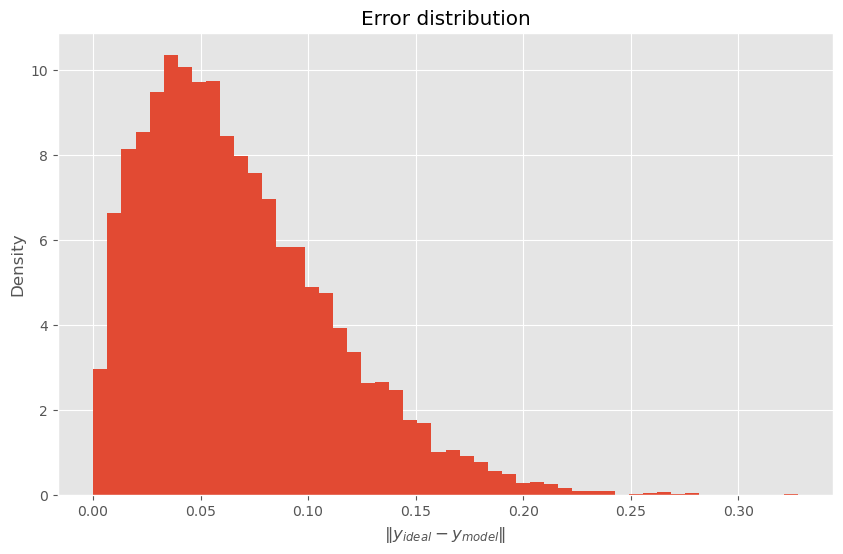

In [19]:
np.random.seed(SEED)

errors = np.zeros(N_REPS)

for i in range(N_REPS):
    u = np.random.uniform(-1, 1, SIZE)
    M = np.random.uniform(-1, 1, (SIZE, SIZE))
    b = np.random.uniform(-1, 1, SIZE)

    # ideal output
    v = M @ u + b

    # model output
    model.set_weights(M, b)
    y = model(torch.Tensor(u)).detach().numpy()

    # compute error
    errors[i] = np.linalg.norm(v - y)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(errors, bins=50, density=True)
ax.set(xlabel=r'$\| y_{ideal}-y_{model}\|$', ylabel='Density', title='Error distribution')
plt.show()